# Find the bad eggs!

## Setup

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

# Folder to get stuff from
name = 'Test'

## Go

In [5]:
data = pd.read_csv('./'+name+'/network.csv')
data

,user,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,user_10,user_11,user_12,user_13,user_14,Average_polarity
0,840727059001417728,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,0.291756
1,23627253,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,0.180467
2,1149011056716500997,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,0.194474
3,1175725425949073409,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,0.283017
4,925904609511690240,False,True,True,True,False,True,False,False,False,False,False,False,False,False,False,0.205797
5,834453600730484736,False,True,False,False,True,False,True,True,False,False,False,False,False,False,False,0.301528
6,1151938716438552577,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.393219
7,92508756,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.171071
8,38720479,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,0.365142
9,18162640,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,0.080877


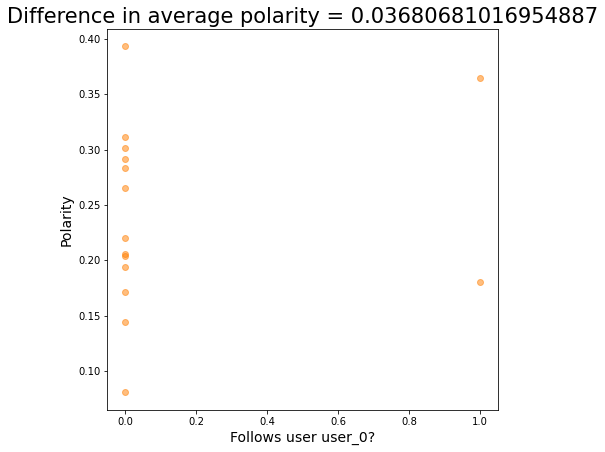

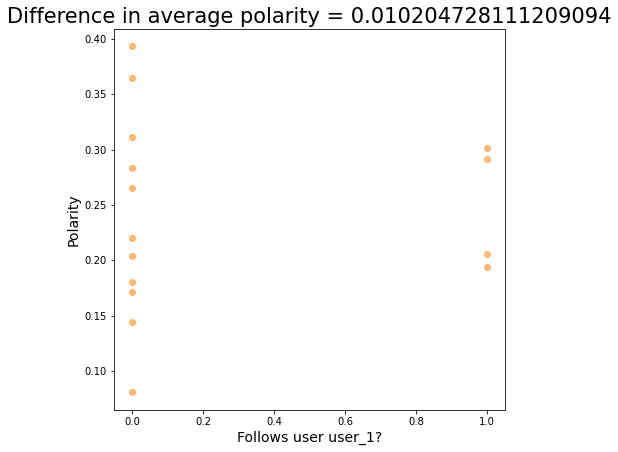

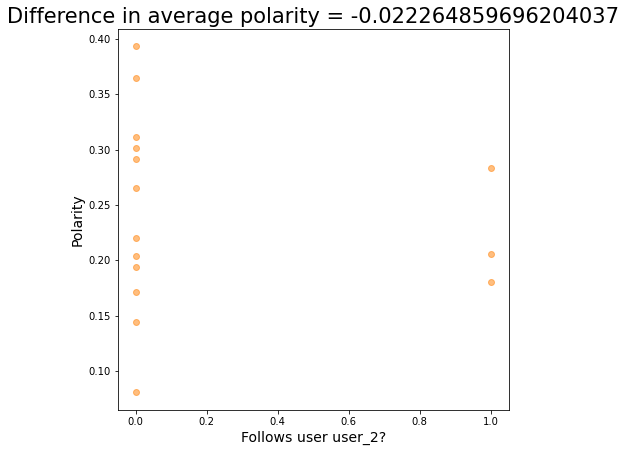

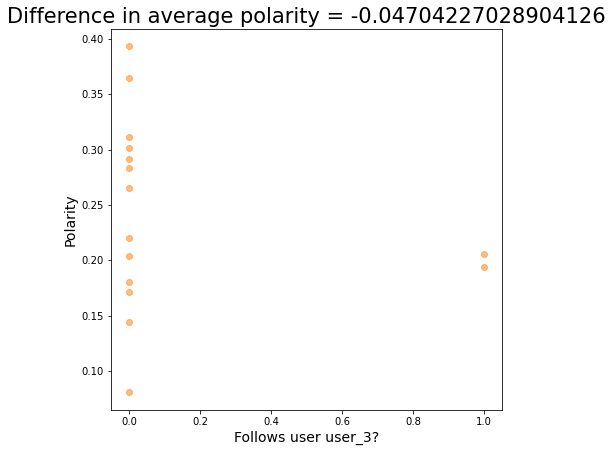

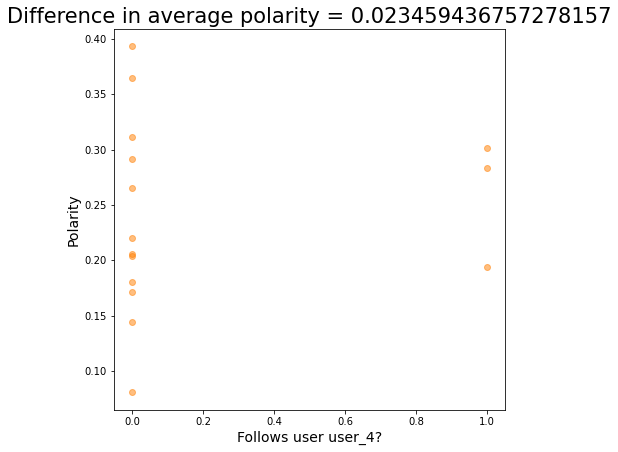

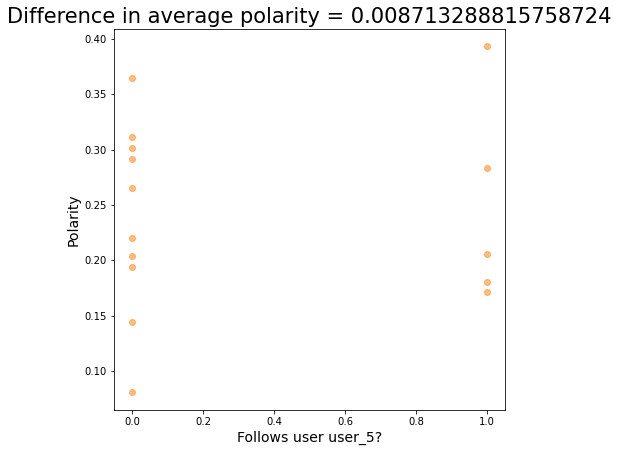

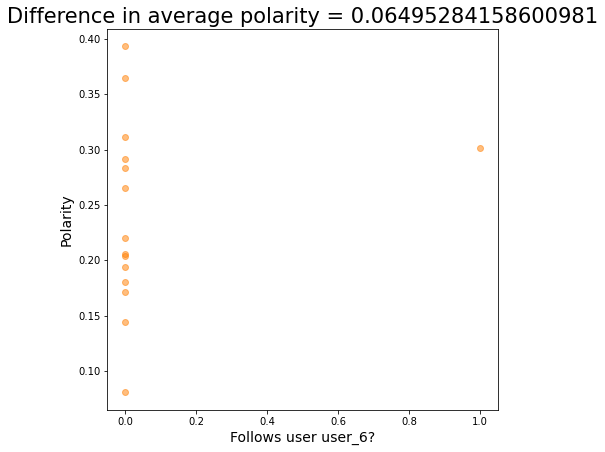

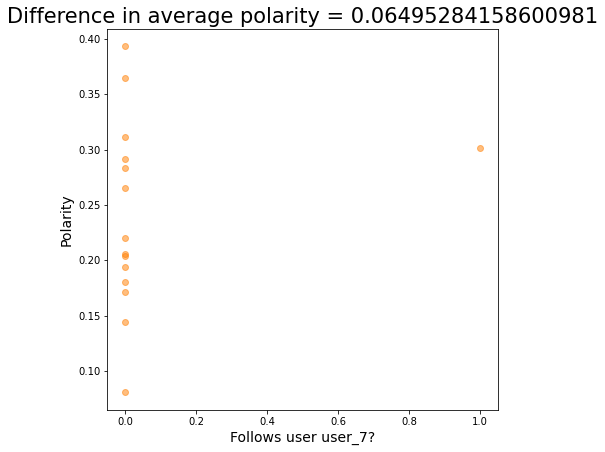

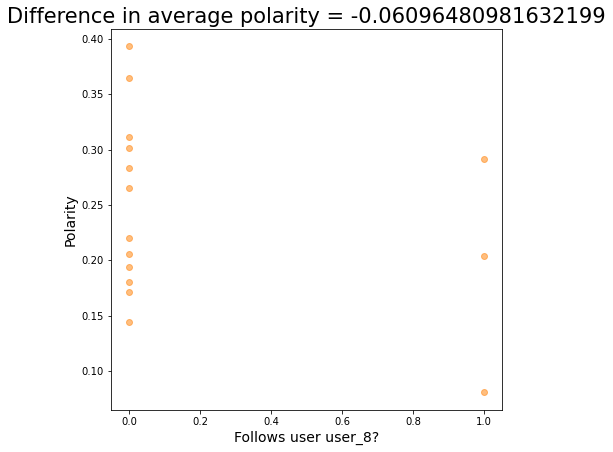

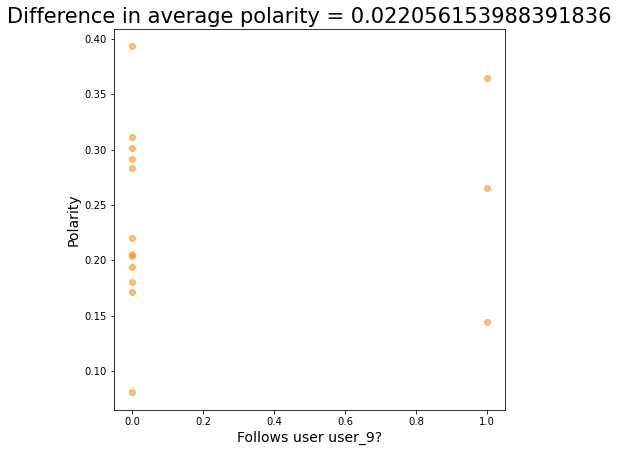

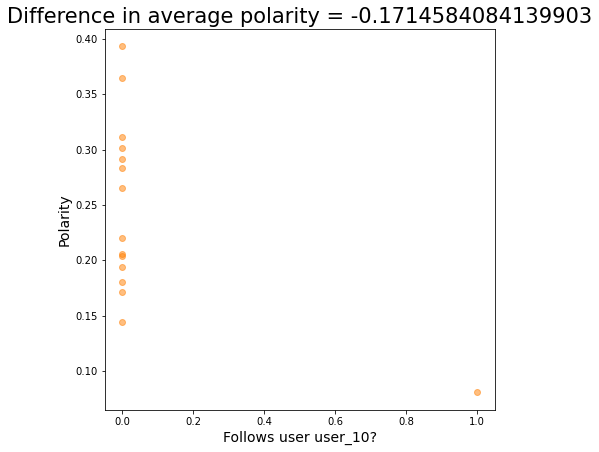

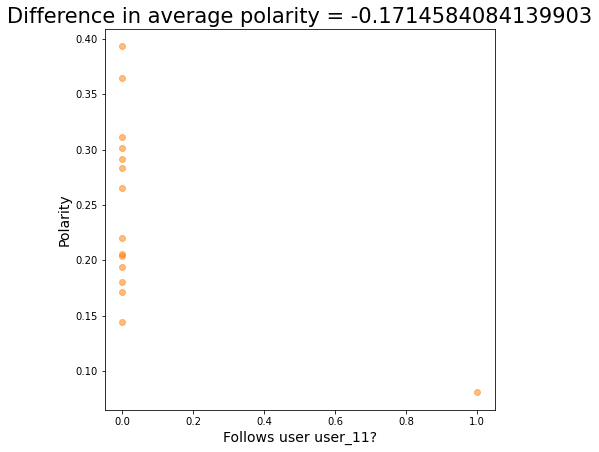

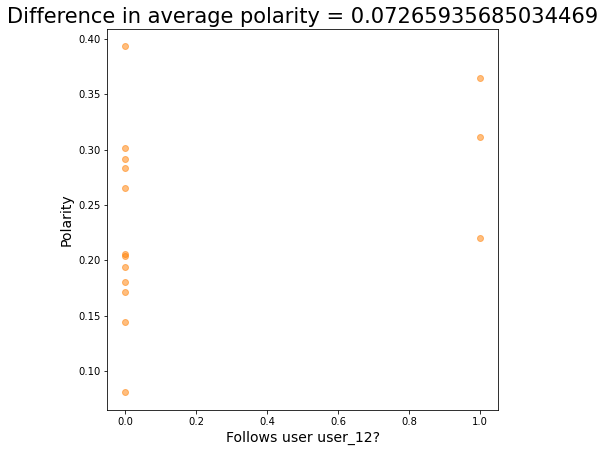

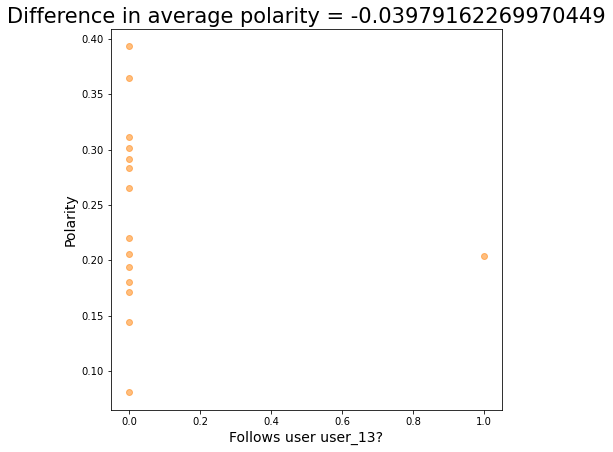

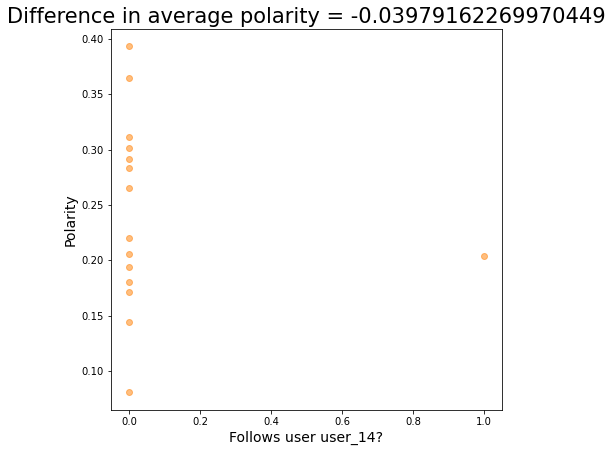

In [7]:
diaps = []
for user in data.columns[1:-1]:
    plt.figure(figsize=(7,7))
    plt.scatter(data[user], data['Average_polarity'], alpha=.5, color='#FF7F00')
    plt.xlabel('Follows user '+user+'?', fontsize=14)
    plt.ylabel('Polarity', fontsize=14)
    diap = list(np.mean(data.loc[data[user]==True, ['Average_polarity']])-np.mean(data.loc[data[user]==False, ['Average_polarity']]))[0]
    diaps.append(diap)
    plt.title('Difference in average polarity = '+str(diap), fontsize=21)
    plt.show()

In [9]:
fit = sm.OLS(data.Average_polarity, 
             sm.add_constant(data[data.columns[1:-1]].astype(int))).fit()
fit.summary()

C:\Users\Ysgard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Average_polarity   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                 -0.674
Method:                 Least Squares   F-statistic:                    0.4878
Date:                Fri, 28 May 2021   Prob (F-statistic):              0.835
Time:                        20:37:46   Log-Likelihood:                 23.922
No. Observations:                  15   AIC:                            -23.84
Df Residuals:                       3   BIC:                            -15.35
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0929      0.142      0.655      0.559      -0.358       0.544
user_0        -0.0132      0.110     -0.120      0.912      -0.363       0.336
user_1         0.0933      0.080      1.167      0.328      -0.161       0.348
user_2        -0.0885      0.119     -0.746      0.510      -0.466       0.289
user_3        -0.0812      0.088     -0.923      0.424      -0.361       0.199
user_4         0.0894      0.110      0.814      0.475      -0.260       0.439
user_5         0.1892      0.162      1.171      0.326      -0.325       0.704
user_6         0.0129      0.070      0.186      0.864      -0.208       0.234
user_7         0.0129      0.070      0.186      0.864      -0.208       0.234
user_8         0.1055      0.112      0.938      0.418      -0.252       0.463
user_9         0.1123      0.134      0.835      0.465      -0.316       0.540
user_10       -0.0588      0.065     -0.898      0.435      -0.267       0.149
user_11       -0.0588      0.065     -0.898      0.435      -0.267       0.149
user_12        0.1731      0.134      1.287      0.288      -0.255       0.601
user_13        0.0027      0.065      0.041      0.970      -0.206       0.211
user_14        0.0027      0.065      0.041      0.970      -0.206       0.211
==============================================================================
Omnibus:                        2.287   Durbin-Watson:                   2.943
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                0.503
Skew:                           0.000   Prob(JB):                        0.777
Kurtosis:                       3.898   Cond. No.                     5.12e+33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The smallest eigenvalue is 8.5e-67. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
diaps = np.array(diaps)
diabz = (diaps-diaps.mean())/diaps.std()
featusers = np.abs(diabz)>=2
featusers = [i+1 for i in range(len(featusers)) if featusers[i]]
featusers = data.columns[featusers]

In [14]:
fit = sm.OLS(data.Average_polarity, 
             sm.add_constant(data[featusers].astype(int))).fit()
fit.summary()

C:\Users\Ysgard\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Average_polarity   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     4.857
Date:                Fri, 28 May 2021   Prob (F-statistic):             0.0462
Time:                        20:39:27   Log-Likelihood:                 18.611
No. Observations:                  15   AIC:                            -33.22
Df Residuals:                      13   BIC:                            -31.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2523      0.020     12.562      0.000       0.209       0.296
user_10       -0.0857      0.039     -2.204      0.046      -0.170      -0.002
user_11       -0.0857      0.039     -2.204      0.046      -0.170      -0.002
==============================================================================
Omnibus:                        0.793   Durbin-Watson:                   2.324
Prob(Omnibus):                  0.673   Jarque-Bera (JB):                0.763
Skew:                           0.400   Prob(JB):                        0.683
Kurtosis:                       2.238   Cond. No.                     1.86e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.4e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
diabz[np.abs(diabz)>=2]

array([-2.11333583, -2.11333583])